=== Dynamic Pricing Forecasting ===
=== Regional-Level Dynamic Pricing Forecasting ===
Region: Bergen - MAE: 0.0229, MSE: 0.0135, R2: 0.9741, MAPE: 0.97%, Rel_MSE: 0.0012
Next 1-hour dynamic pricing prediction for Bergen: 3.2280
Region: Oslo - MAE: 0.0145, MSE: 0.0113, R2: 0.9748, MAPE: 0.83%, Rel_MSE: 0.0010
Next 1-hour dynamic pricing prediction for Oslo: 3.2306
Region: Stavanger - MAE: 0.1233, MSE: 0.3646, R2: 0.1220, MAPE: 5.79%, Rel_MSE: 0.0332
Next 1-hour dynamic pricing prediction for Stavanger: 3.2575

=== National-Level Dynamic Pricing Forecasting ===
National Dynamic Pricing - MAE: 0.0124, MSE: 0.0085, R2: 0.9805, MAPE: 0.63%, Rel_MSE: 0.0008
Next 1-hour dynamic pricing prediction at 2020-03-21 00:00:00: 3.2397

Next 24 Hours Dynamic Pricing Predictions:
2020-03-21 00:00:00: 3.2397
2020-03-21 01:00:00: 3.2396
2020-03-21 02:00:00: 3.2396
2020-03-21 03:00:00: 3.2397
2020-03-21 04:00:00: 3.2399
2020-03-21 05:00:00: 3.2400
2020-03-21 06:00:00: 3.2402
2020-03-21 07:00:00: 3.2402
2

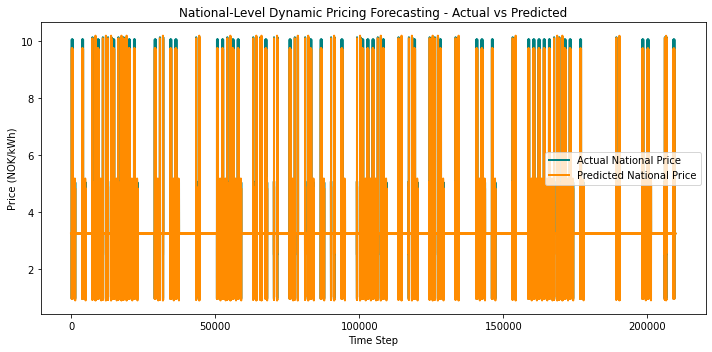

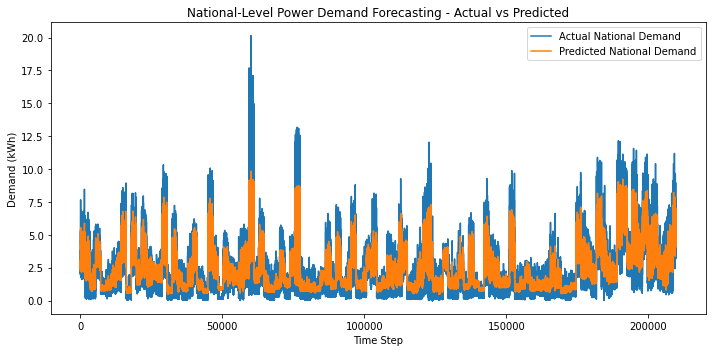

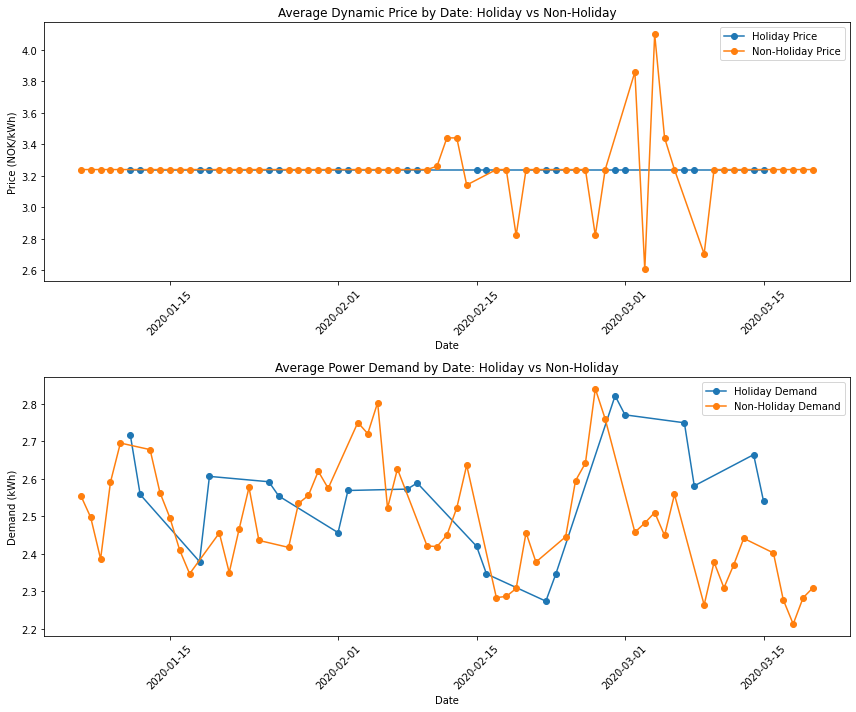

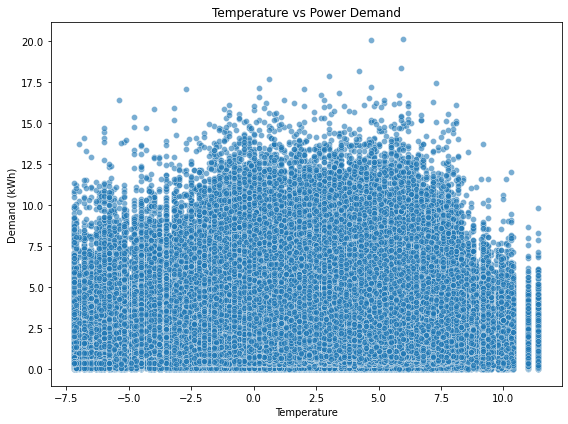

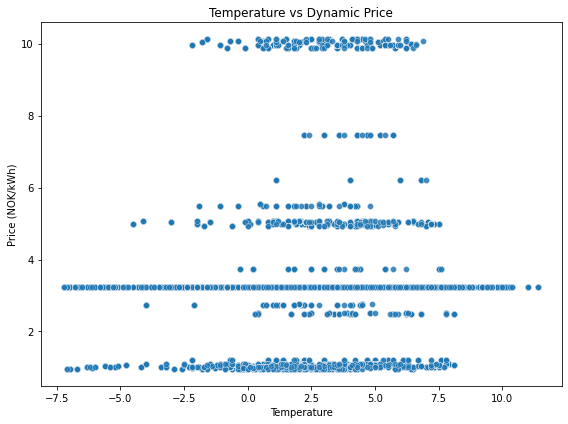

In [1]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import holidays
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# 1. Data Loading and Preparation
# ============================
hourly_data = pd.read_csv(r"C:\Users\Vishnu\Downloads\data_hourly.csv")
participants = pd.read_csv(r"C:\Users\Vishnu\Downloads\participants.csv")
price_signals = pd.read_csv(r"C:\Users\Vishnu\Downloads\price_signals.csv")

# Merge Region from participants into hourly_data
hourly_data = hourly_data.merge(participants[["ID", "Region"]], on="ID", how="left")

# Select basic features and create new dataframe
feature_list = ["ID", "From", "Participation_Phase", "Demand_kWh", "Price_signal", "Temperature", "Region"]
new_data = hourly_data[feature_list].copy()

# Parse datetime and extract date/time features
new_data["From"] = pd.to_datetime(new_data["From"])
new_data["Date"] = new_data["From"].dt.date
new_data["Hour"] = new_data["From"].dt.hour + 1

# Merge in price signals (bringing in Experiment_price_NOK_kWh)
price_signals_features = ["Price_signal", "Hour", "Experiment_price_NOK_kWh"]
new_data = new_data.merge(price_signals[price_signals_features], on=["Price_signal", "Hour"], how="left")

# Merge additional participant features if needed
participants_features = ["ID", "Participation_Experiment", "Municipality", "Survey3_answered"]
new_data = new_data.merge(participants[participants_features], on="ID", how="left")

# Create combined datetime column
new_data["datetime"] = pd.to_datetime(new_data["Date"]) + pd.to_timedelta(new_data["Hour"] - 1, unit='h')

# Create two copies:
dp_data = new_data.copy()     # For dynamic pricing forecasting
power_data = new_data.copy()  # For power/demand forecasting

# ============================
# 2. Build Model and Sequence Functions
# ============================
def build_model(input_shape):
    """Basic LSTM architecture."""
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_sequences(df, feature_cols, target_col, time_steps=24):
    """General sequence creator for given features and target."""
    data = df[feature_cols + [target_col]].values.astype(np.float32)
    X = np.array([data[i:i+time_steps] for i in range(len(data) - time_steps)])
    y = data[time_steps:, -1]
    return X, y

# ============================
# 3. Evaluation Metrics 
# ============================
def evaluate_metrics(y_true, y_pred, label=""):
    """
    Prints evaluation metrics: MAE, MSE, R2, MAPE, and Relative MSE.
    Arrays are flattened to avoid broadcasting issues.
    """
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    mae_val = mean_absolute_error(y_true, y_pred)
    mse_val = mean_squared_error(y_true, y_pred)
    r2_val = r2_score(y_true, y_pred)
    
    epsilon = 1e-8  # avoid division by zero
    mape_val = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon))) * 100
    rel_mse_val = mse_val / np.mean(y_true**2)
    
    print(f"{label}MAE: {mae_val:.4f}, MSE: {mse_val:.4f}, R2: {r2_val:.4f}, " 
          f"MAPE: {mape_val:.2f}%, Rel_MSE: {rel_mse_val:.4f}")

# ============================
# 4. Dynamic Pricing Forecasting
# ============================
print("=== Dynamic Pricing Forecasting ===")

# Feature engineering for dynamic pricing
dp_data["Temperature_orig"] = dp_data["Temperature"]
dp_data["Date_dt"] = pd.to_datetime(dp_data["Date"])
dp_data["Day_of_week"] = dp_data["Date_dt"].dt.weekday
dp_data["Weekend"] = dp_data["Day_of_week"] > 4

norway_holidays = holidays.Norway()
dp_data["Holiday"] = (dp_data["Date_dt"].isin(norway_holidays) | dp_data["Weekend"]).astype(bool)
dp_data["Dynamic_Pricing"] = (dp_data["Experiment_price_NOK_kWh"] > 0).astype(int)
dp_data["Region_Original"] = dp_data["Region"]

# Define features for dynamic pricing
dp_cat_features = ["ID", "Participation_Phase", "Price_signal", "Municipality", "Region"]
dp_price_features = ["Temperature", "Hour", "Day_of_week", "Holiday", "Weekend", "Dynamic_Pricing"]
price_target = "Experiment_price_NOK_kWh"

# Encode categorical features
encoder = LabelEncoder()
for col in dp_cat_features:
    dp_data[col] = encoder.fit_transform(dp_data[col].astype(str))

# Scale numerical features and target
scaler_price = MinMaxScaler()
dp_data[dp_price_features] = scaler_price.fit_transform(dp_data[dp_price_features])
target_scaler_price = MinMaxScaler()
dp_data[[price_target]] = target_scaler_price.fit_transform(dp_data[[price_target]])

dp_data["Price_orig"] = target_scaler_price.inverse_transform(dp_data[[price_target]])
dp_data["Price_orig"].fillna(dp_data["Price_orig"].mean(), inplace=True)
for col in dp_price_features + [price_target]:
    dp_data[col].fillna(dp_data[col].mean(), inplace=True)

sequence_length = 24

# --- Regional-Level Dynamic Pricing Forecasting ---
print("=== Regional-Level Dynamic Pricing Forecasting ===")
dp_region_forecasts = {}
dp_region_models = {}
dp_region_results = {}

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
epochs_dp = 3

for region_val in dp_data["Region"].unique():
    region_data = dp_data[dp_data["Region"] == region_val]
    X_dp, y_dp = create_sequences(region_data, dp_price_features, price_target, time_steps=sequence_length)
    if len(X_dp) == 0:
        continue
    split_dp = int(len(X_dp) * 0.8)
    X_train_dp, X_test_dp = X_dp[:split_dp], X_dp[split_dp:]
    y_train_dp, y_test_dp = y_dp[:split_dp], y_dp[split_dp:]
    
    model_dp = build_model((sequence_length, X_dp.shape[2]))
    model_dp.fit(X_train_dp, y_train_dp, validation_data=(X_test_dp, y_test_dp),
                 epochs=epochs_dp, batch_size=32, callbacks=[early_stopping], verbose=0)
    
    y_pred_dp = model_dp.predict(X_test_dp, verbose=0)
    y_pred_dp_orig = target_scaler_price.inverse_transform(y_pred_dp)
    y_test_dp_orig = target_scaler_price.inverse_transform(y_test_dp.reshape(-1, 1))
    
    region_name = region_data["Region_Original"].iloc[0]
    evaluate_metrics(y_test_dp_orig, y_pred_dp_orig, label=f"Region: {region_name} - ")
    
    if len(region_data) >= sequence_length:
        last_24_dp = region_data[dp_price_features + [price_target]].values.astype(np.float32)[-sequence_length:]
        last_24_dp = last_24_dp.reshape(1, sequence_length, len(dp_price_features) + 1)
        next_hour_dp = model_dp.predict(last_24_dp, verbose=0)[0][0]
        next_hour_dp_orig = target_scaler_price.inverse_transform([[next_hour_dp]])[0][0]
        print(f"Next 1-hour dynamic pricing prediction for {region_name}: {next_hour_dp_orig:.4f}")
        dp_region_forecasts[region_name] = next_hour_dp_orig
    else:
        print(f"Not enough data for next 1-hour prediction for {region_name}")
    
    dp_region_models[region_val] = model_dp
    dp_region_results[region_name] = {
        "actual": y_test_dp_orig.flatten(), 
        "predicted": y_pred_dp_orig.flatten()
    }

# --- National-Level Dynamic Pricing Forecasting ---
print("\n=== National-Level Dynamic Pricing Forecasting ===")
X_dp_nat, y_dp_nat = create_sequences(dp_data, dp_price_features, price_target, time_steps=sequence_length)
split_dp_nat = int(len(X_dp_nat) * 0.8)
X_train_dp_nat, X_test_dp_nat = X_dp_nat[:split_dp_nat], X_dp_nat[split_dp_nat:]
y_train_dp_nat, y_test_dp_nat = y_dp_nat[:split_dp_nat], y_dp_nat[split_dp_nat:]
national_dp_model = build_model((sequence_length, X_dp_nat.shape[2]))
national_dp_model.fit(X_train_dp_nat, y_train_dp_nat,
                      validation_data=(X_test_dp_nat, y_test_dp_nat),
                      epochs=epochs_dp, batch_size=32, callbacks=[early_stopping], verbose=0)
y_pred_dp_nat = national_dp_model.predict(X_test_dp_nat, verbose=0)
y_pred_dp_nat_orig = target_scaler_price.inverse_transform(y_pred_dp_nat)
y_test_dp_nat_orig = target_scaler_price.inverse_transform(y_test_dp_nat.reshape(-1, 1))
evaluate_metrics(y_test_dp_nat_orig, y_pred_dp_nat_orig, label="National Dynamic Pricing - ")

last_24_dp_nat = dp_data[dp_price_features + [price_target]].values.astype(np.float32)[-sequence_length:]
last_24_dp_nat = last_24_dp_nat.reshape(1, sequence_length, len(dp_price_features) + 1)
next_hour_dp_nat = national_dp_model.predict(last_24_dp_nat, verbose=0)[0][0]
next_hour_dp_nat_orig = target_scaler_price.inverse_transform([[next_hour_dp_nat]])[0][0]
future_time_dp_1h = dp_data['datetime'].max() + pd.Timedelta(hours=1)
print(f"Next 1-hour dynamic pricing prediction at {future_time_dp_1h}: {next_hour_dp_nat_orig:.4f}")

# Multi-step forecast for dynamic pricing
multi_preds_dp = []
current_seq_dp = last_24_dp_nat.copy()
for i in range(24):
    pred = national_dp_model.predict(current_seq_dp, verbose=0)[0][0]
    multi_preds_dp.append(pred)
    new_row = current_seq_dp[0, -1, :].copy()
    new_row[-1] = pred
    current_seq_dp = np.concatenate([current_seq_dp[:, 1:, :], new_row.reshape(1, 1, -1)], axis=1)
multi_preds_dp_orig = target_scaler_price.inverse_transform(np.array(multi_preds_dp).reshape(-1,1)).flatten()
last_timestamp_dp = dp_data['datetime'].max()
future_times_dp = [last_timestamp_dp + pd.Timedelta(hours=i+1) for i in range(24)]
print("\nNext 24 Hours Dynamic Pricing Predictions:")
for t, p in zip(future_times_dp, multi_preds_dp_orig):
    print(f"{t}: {p:.4f}")

# ============================
# 5. Power Demand Forecasting
# ============================
print("\n=== Power Demand Forecasting ===")

power_data["Demand_orig"] = power_data["Demand_kWh"].copy()
power_data["Temperature_orig"] = power_data["Temperature"].copy()
power_data["Date_dt"] = pd.to_datetime(power_data["Date"])
power_data["Day_of_week"] = power_data["Date_dt"].dt.weekday
power_data["Weekend"] = power_data["Day_of_week"] > 4
power_data["Holiday"] = ((power_data["Date_dt"].isin(norway_holidays)) | (power_data["Weekend"])).astype(bool)
power_data["Dynamic_Pricing"] = (power_data["Experiment_price_NOK_kWh"] > 0).astype(int)

# Create lag and rolling features for demand
for lag in [1, 3, 24, 168]:
    power_data[f'lag_{lag}'] = power_data['Demand_kWh'].shift(lag)
for window in [3, 24, 168]:
    power_data[f'rolling_mean_{window}'] = power_data['Demand_kWh'].rolling(window).mean()

power_cont_features = [
    "Temperature", "Hour", "Experiment_price_NOK_kWh", "Day_of_week", "Weekend",
    "Holiday", "Dynamic_Pricing", "lag_1", "lag_3", "lag_24", "lag_168",
    "rolling_mean_3", "rolling_mean_24", "rolling_mean_168", "Demand_kWh"
]
for col in power_cont_features:
    power_data[col].fillna(power_data[col].mean(), inplace=True)

power_data["Region_Original"] = power_data["Region"]

power_cat_features = ["ID", "Participation_Phase", "Price_signal", "Municipality", "Region"]
for col in power_cat_features:
    power_data[col] = encoder.fit_transform(power_data[col].astype(str))

power_model_features = power_cat_features + [col for col in power_cont_features if col != "Demand_kWh"]
power_target = "Demand_kWh"

scaler_power = MinMaxScaler()
power_data[power_cont_features] = scaler_power.fit_transform(power_data[power_cont_features])
epochs_power = 3

print("=== Regional-Level Demand Forecasting ===")
power_models = {}
power_region_results = {}
national_data_list = []

for region_val in power_data["Region"].unique():
    region_data = power_data[power_data["Region"] == region_val]
    X_power, y_power = create_sequences(region_data, power_model_features, power_target, time_steps=sequence_length)
    if len(X_power) == 0:
        continue
    split = int(len(X_power) * 0.8)
    X_train, X_test = X_power[:split], X_power[split:]
    y_train, y_test = y_power[:split], y_power[split:]
    
    model_power = build_model((sequence_length, X_power.shape[2]))
    model_power.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs_power, batch_size=32, callbacks=[early_stopping], verbose=0)
    
    y_pred = model_power.predict(X_test)
    region_name = region_data["Region_Original"].iloc[0]
    evaluate_metrics(y_test, y_pred, label=f"Region: {region_name} - ")
    
    if len(region_data) >= sequence_length:
        last_24 = region_data[power_model_features + [power_target]].values.astype(np.float32)[-sequence_length:]
        last_24 = last_24.reshape(1, sequence_length, len(power_model_features) + 1)
        next_hour_pred = model_power.predict(last_24)[0][0]
        print(f"Next 1-hour power demand prediction for {region_name}: {next_hour_pred:.4f}")
    else:
        print(f"Not enough data for next 1-hour prediction for {region_name}")
    
    power_models[region_val] = model_power
    national_data_list.append(region_data)
    power_region_results[region_name] = {"actual": y_test, "predicted": y_pred.flatten()}

# --- National-Level Demand Forecasting ---
print("\n=== National-Level Demand Forecasting ===")
national_data = pd.concat(national_data_list)
X_nat, y_nat = create_sequences(national_data, power_model_features, power_target, time_steps=sequence_length)
split_nat = int(len(X_nat) * 0.8)
X_train_nat, X_test_nat = X_nat[:split_nat], X_nat[split_nat:]
y_train_nat, y_test_nat = y_nat[:split_nat], y_nat[split_nat:]
national_power_model = build_model((sequence_length, X_nat.shape[2]))
national_power_model.fit(X_train_nat, y_train_nat, validation_data=(X_test_nat, y_test_nat),
                         epochs=epochs_power, batch_size=32, callbacks=[early_stopping], verbose=0)
y_pred_nat = national_power_model.predict(X_test_nat)
evaluate_metrics(y_test_nat, y_pred_nat, label="National Power Demand - ")

# Next-hour forecast for national power demand
last_24_nat = power_data[power_model_features + [power_target]].values.astype(np.float32)[-sequence_length:]
last_24_nat = last_24_nat.reshape(1, sequence_length, len(power_model_features) + 1)
next_hour_nat = national_power_model.predict(last_24_nat, verbose=0)[0][0]
print(f"Next 1-hour power demand prediction: {next_hour_nat:.4f}")
future_time_power_1h = power_data['datetime'].max() + pd.Timedelta(hours=1)
print(f"Next 1-hour power demand prediction at {future_time_power_1h}")

demand_index = power_cont_features.index("Demand_kWh")
demand_min = scaler_power.data_min_[demand_index]
demand_max = scaler_power.data_max_[demand_index]

multi_preds_power = []
current_seq_power = last_24_nat.copy()
for i in range(24):
    pred = national_power_model.predict(current_seq_power, verbose=0)[0][0]
    multi_preds_power.append(pred)
    new_row = current_seq_power[0, -1, :].copy()
    new_row[-1] = pred
    current_seq_power = np.concatenate([current_seq_power[:, 1:, :], new_row.reshape(1, 1, -1)], axis=1)
multi_preds_power_orig = np.array(multi_preds_power) * (demand_max - demand_min) + demand_min
last_timestamp_power = power_data['datetime'].max()
future_times_power = [last_timestamp_power + pd.Timedelta(hours=i+1) for i in range(24)]
print("\nNext 24 Hours Power Demand Predictions:")
for t, d in zip(future_times_power, multi_preds_power_orig):
    print(f"{t}: {d:.4f}")

# ============================
# 6. Visualizations
# ============================

# Actual vs. Predicted: Dynamic Pricing (National)
plt.figure(figsize=(10, 5))
plt.plot(y_test_dp_nat_orig.flatten(), color='teal', linewidth=2, label="Actual National Price")
plt.plot(y_pred_dp_nat_orig.flatten(), color='darkorange', linewidth=2, label="Predicted National Price")
plt.title("National-Level Dynamic Pricing Forecasting - Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("Price (NOK/kWh)")
plt.legend()
plt.tight_layout()
plt.show()

# Actual vs. Predicted: Power Demand (National)
y_test_nat_inv = y_test_nat * (demand_max - demand_min) + demand_min
y_pred_nat_inv = y_pred_nat * (demand_max - demand_min) + demand_min
plt.figure(figsize=(10, 5))
plt.plot(y_test_nat_inv.flatten(), label="Actual National Demand")
plt.plot(y_pred_nat_inv.flatten(), label="Predicted National Demand")
plt.title("National-Level Power Demand Forecasting - Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("Demand (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

# Update Holiday Flags for consistency
dp_data["Holiday"] = (dp_data["Date_dt"].isin(norway_holidays) | dp_data["Weekend"]).astype(bool)
power_data["Holiday"] = ((power_data["Date_dt"].isin(norway_holidays)) | (power_data["Weekend"])).astype(bool)

# Create Date-Only Columns for Grouping
dp_data['Date_only'] = pd.to_datetime(dp_data['Date']).dt.date
power_data['Date_only'] = pd.to_datetime(power_data['Date']).dt.date

# Aggregate for Dynamic Pricing
holiday_price = dp_data[dp_data['Holiday'] == True].groupby('Date_only')['Price_orig'].mean().reset_index()
nonholiday_price = dp_data[dp_data['Holiday'] == False].groupby('Date_only')['Price_orig'].mean().reset_index()

# Aggregate for Power Demand
holiday_demand = power_data[power_data['Holiday'] == True].groupby('Date_only')['Demand_orig'].mean().reset_index()
nonholiday_demand = power_data[power_data['Holiday'] == False].groupby('Date_only')['Demand_orig'].mean().reset_index()

# Sort aggregated data by date
holiday_price.sort_values('Date_only', inplace=True)
nonholiday_price.sort_values('Date_only', inplace=True)
holiday_demand.sort_values('Date_only', inplace=True)
nonholiday_demand.sort_values('Date_only', inplace=True)

# Plot Holiday Analysis for Dynamic Pricing and Power Demand
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
axes[0].plot(holiday_price['Date_only'], holiday_price['Price_orig'], marker='o', label='Holiday Price')
axes[0].plot(nonholiday_price['Date_only'], nonholiday_price['Price_orig'], marker='o', label='Non-Holiday Price')
axes[0].set_title("Average Dynamic Price by Date: Holiday vs Non-Holiday")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price (NOK/kWh)")
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[1].plot(holiday_demand['Date_only'], holiday_demand['Demand_orig'], marker='o', label='Holiday Demand')
axes[1].plot(nonholiday_demand['Date_only'], nonholiday_demand['Demand_orig'], marker='o', label='Non-Holiday Demand')
axes[1].set_title("Average Power Demand by Date: Holiday vs Non-Holiday")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Demand (kWh)")
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Scatter plot: Temperature vs Power Demand
plt.figure(figsize=(8, 6))
sns.scatterplot(data=power_data, x="Temperature_orig", y="Demand_orig", alpha=0.6)
plt.title("Temperature vs Power Demand")
plt.xlabel("Temperature")
plt.ylabel("Demand (kWh)")
plt.tight_layout()
plt.show()

# Scatter plot: Temperature vs Dynamic Price
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dp_data, x="Temperature_orig", y="Price_orig", alpha=0.6)
plt.title("Temperature vs Dynamic Price")
plt.xlabel("Temperature")
plt.ylabel("Price (NOK/kWh)")
plt.tight_layout()
plt.show()
